# Detecção de materiais cortantes    

A FIAP VisionGuard, empresa de monitoramento de câmeras de 
segurança, está analisando a viabilidade de uma nova funcionalidade para 
otimizar o seu software.  
O objetivo da empresa é usar de novas tecnologias para identificar 
situações atípicas e que possam colocar em risco a segurança de 
estabelecimentos e comércios que utilizam suas câmeras.  
Um dos principais desafios da empresa é utilizar Inteligência Artificial 
para identificar objetos cortantes (facas, tesouras e similares) e emitir alertas 
para a central de segurança.  
A empresa tem o objetivo de validar a viabilidade dessa feature, e para 
isso, será necessário fazer um MVP para detecção supervisionada desses 
objetos. 

Objetivos 
* Construir ou buscar um dataset contendo imagens de facas, tesouras e 
outros objetos cortantes em diferentes condições de ângulo e 
iluminação; 
* Anotar o dataset para treinar o modelo supervisionado, incluindo 
imagens negativas (sem objetos perigosos) para reduzir falsos positivos; 
* Treinar o modelo; 
* Desenvolver um sistema de alertas (pode ser um e-mail). 

<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>🗂️1. Install libraries and Download a pre-trained checkpoint 🗂️</b></font>
</div>

In [1]:
!pip install ultralytics
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

Defaulting to user installation because normal site-packages is not writeable


<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>📊 3. Data Visualization 📊</b></font>
</div>

Data analysis is in process...

Data analysis is in process...

Data analysis is in process...



/tmp/ipykernel_13121/3298148329.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)
/tmp/ipykernel_13121/3298148329.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)
/tmp/ipykernel_13121/3298148329.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)


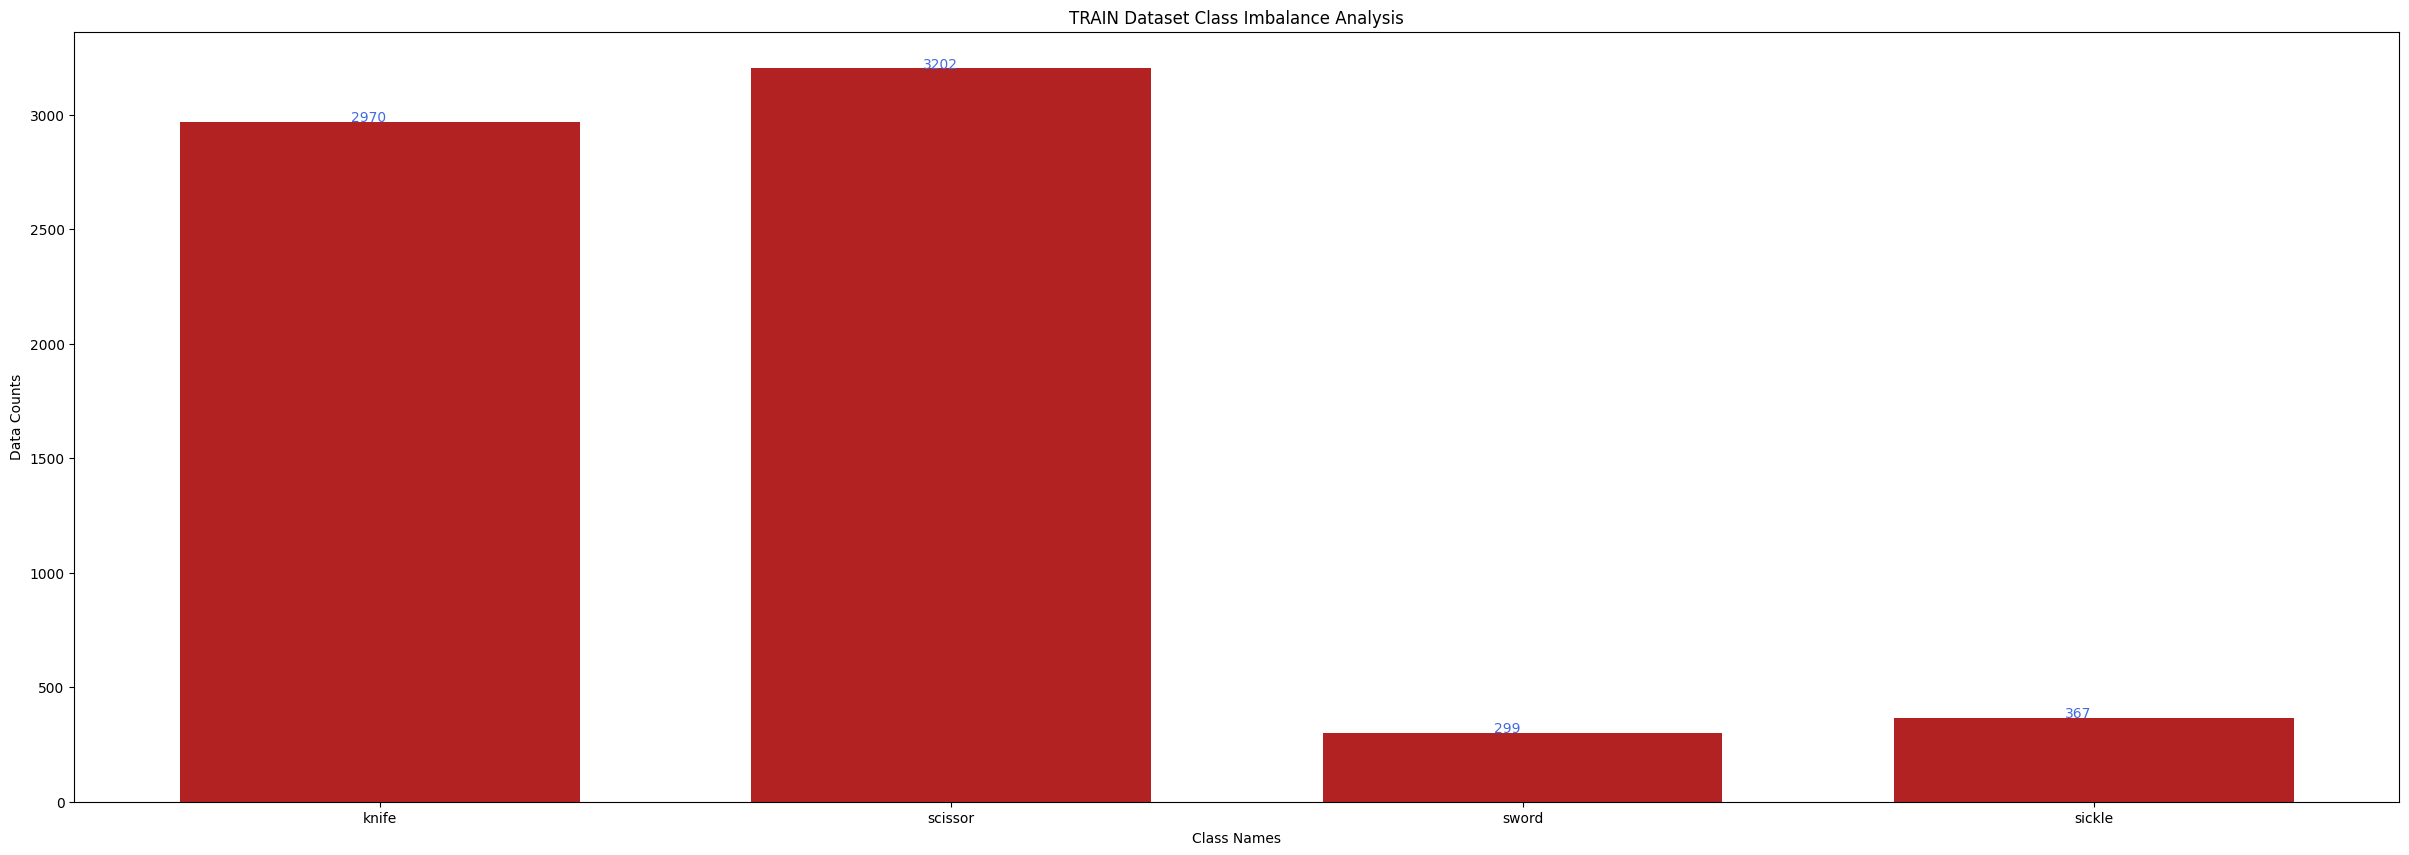

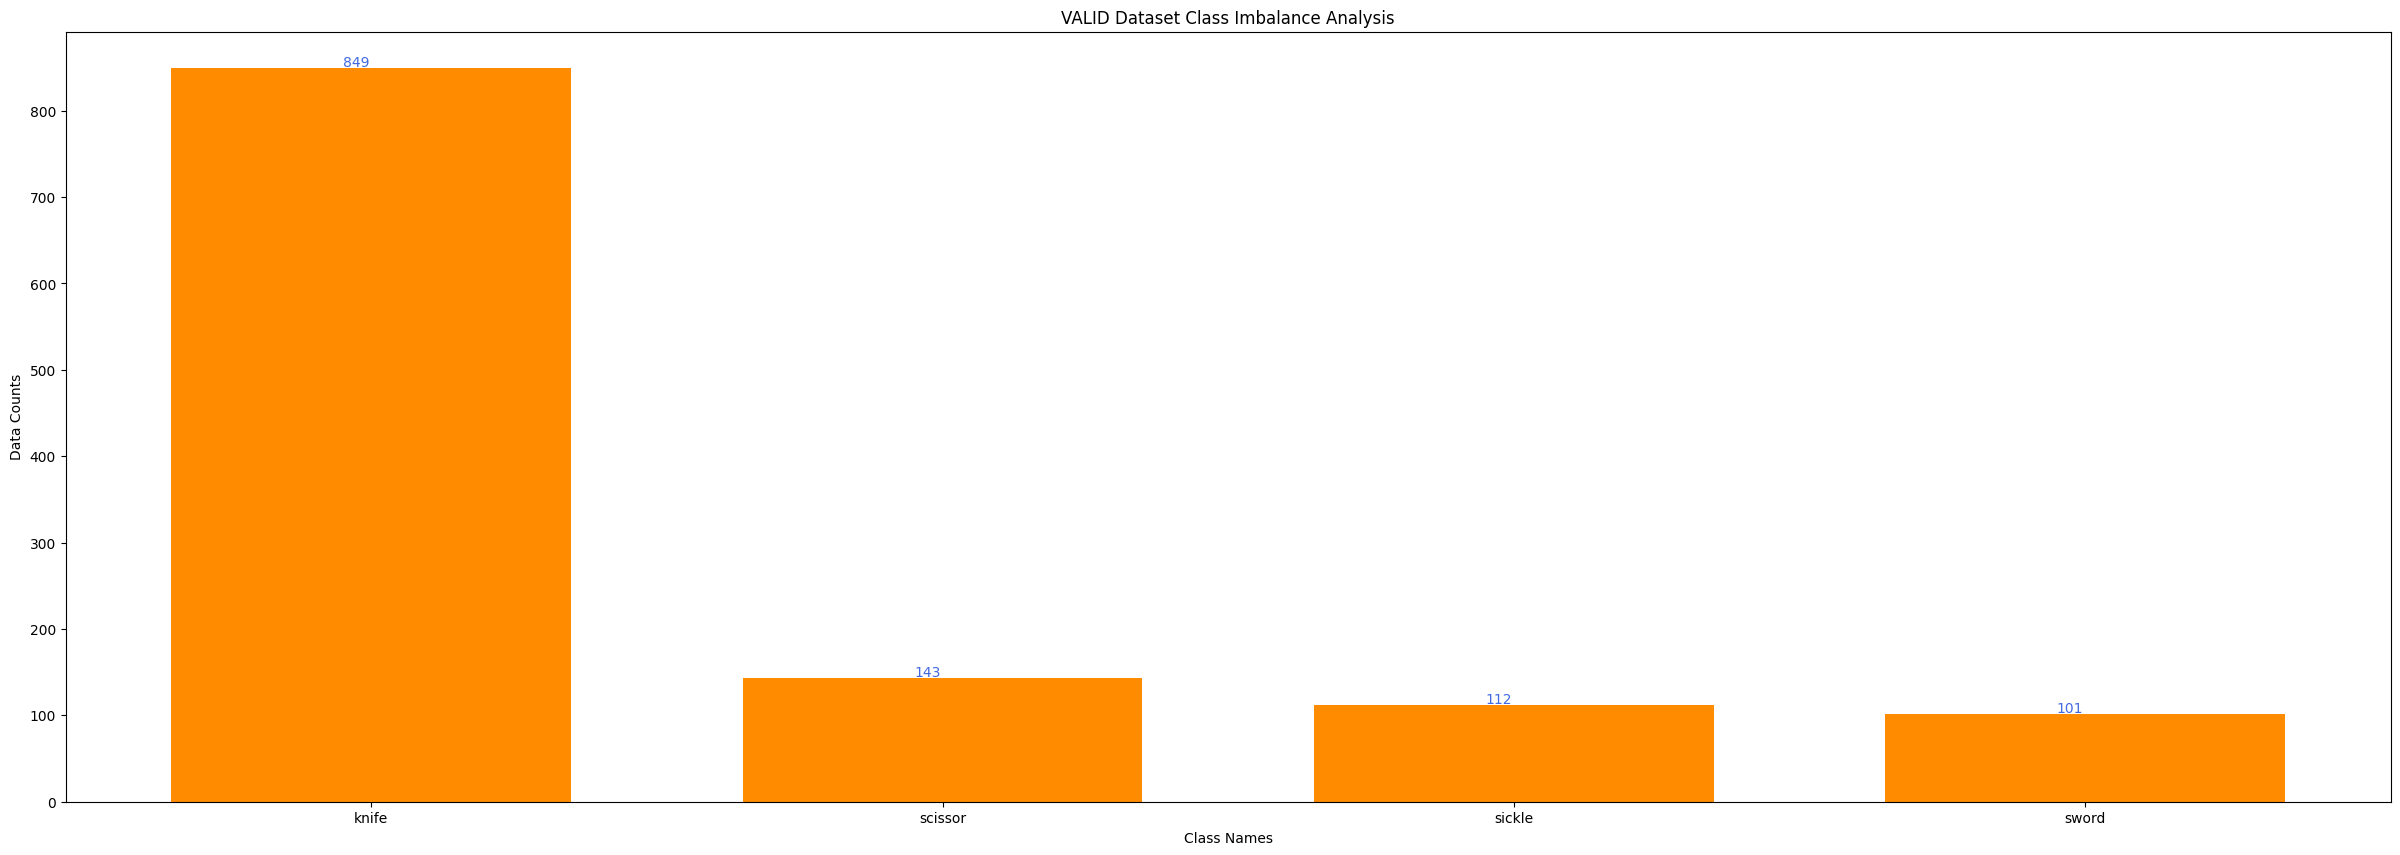

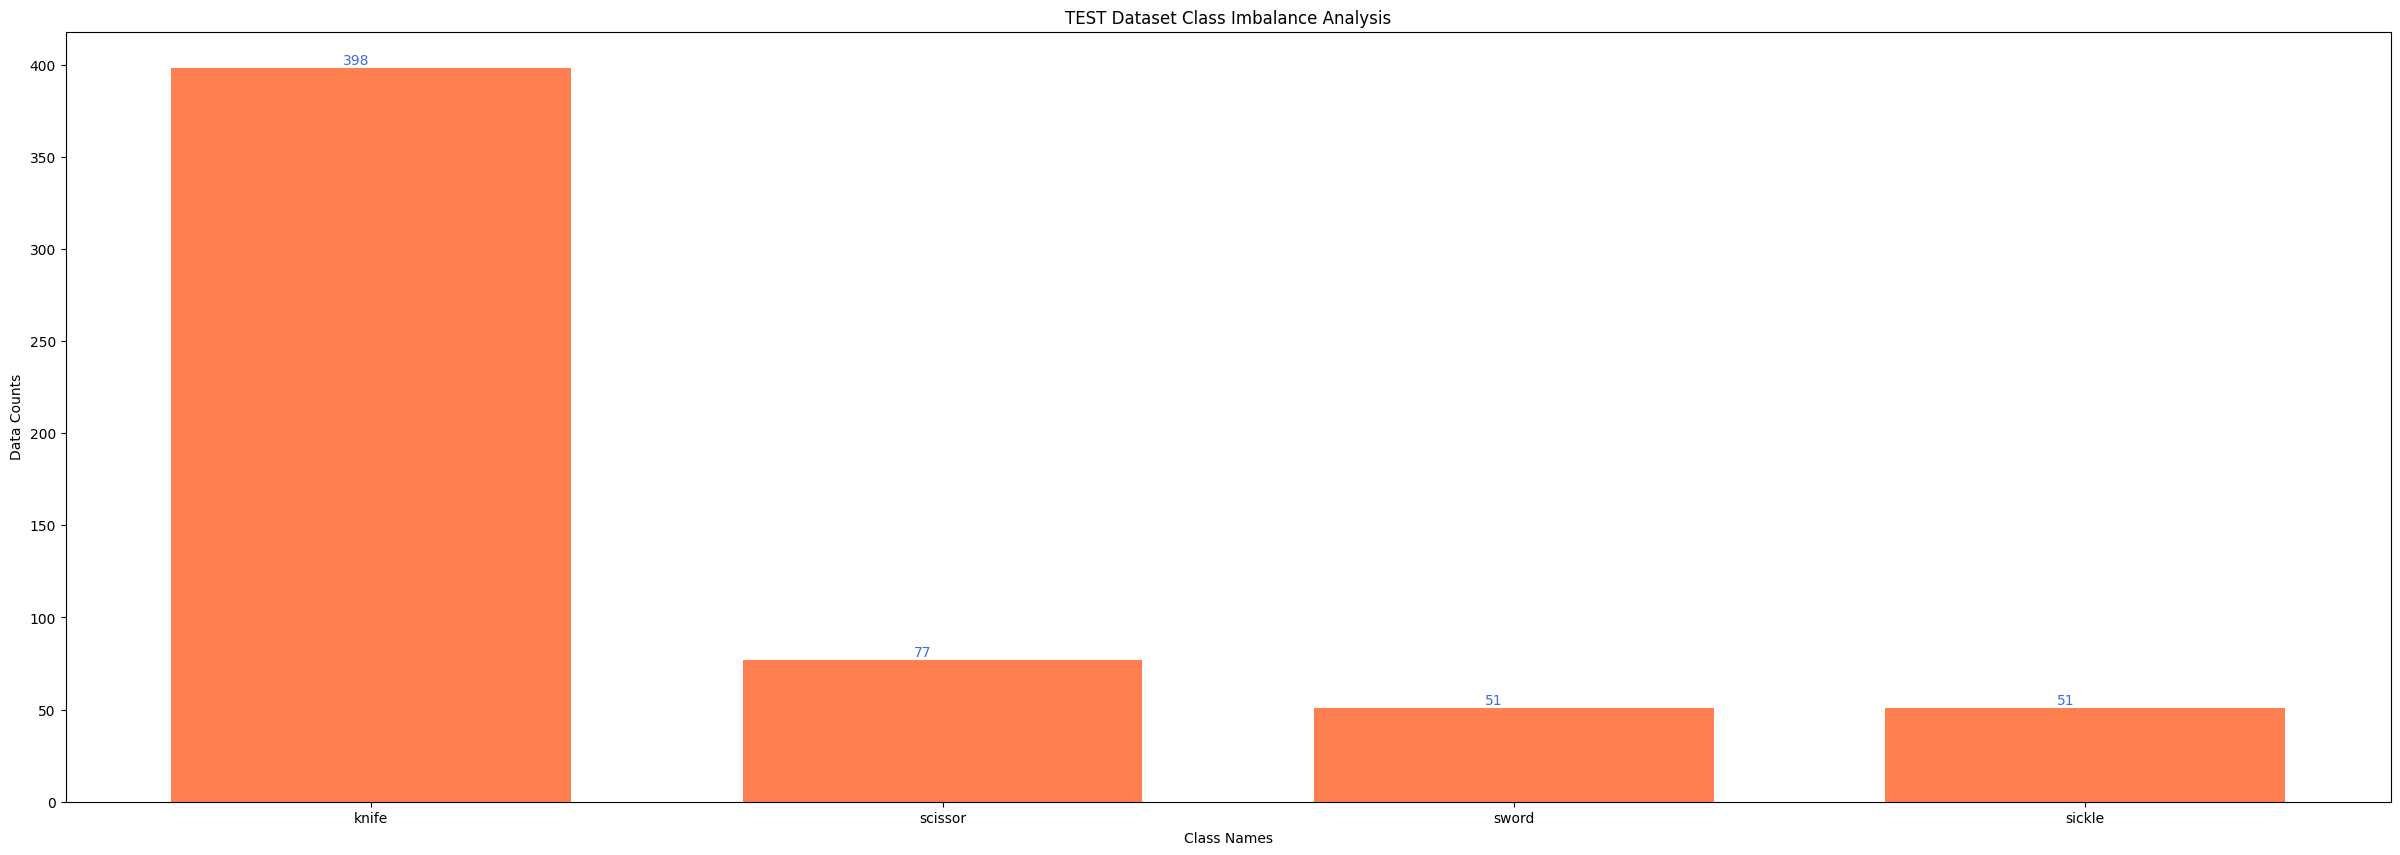

In [2]:
import cv2, yaml, random, numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms as T
from glob import glob
import os


HOME = "/mnt/c/PESSOAL/FIAP/project005"

class Visualization:

    def __init__(self, data_types, n_ims, rows, cmap = None):

        self.n_ims, self.rows = n_ims, rows
        self.cmap, self.data_types  = cmap, data_types
        self.colors = ["firebrick", "darkorange", "coral"]
        
        self.get_cls_names(); self.get_bboxes()        
                
    def get_cls_names(self):

        with open(f"{HOME}/datasets/data.yaml", 'r') as file: data = yaml.safe_load(file)      
        # Extract class names
        class_names = data['names']
        # Create a dictionary with index as key and class name as value
        self.class_dict = {index: name for index, name in enumerate(class_names)}        
    
    def get_bboxes(self):

        self.vis_datas, self.analysis_datas, self.im_paths = {}, {}, {}
        for data_type in self.data_types:
            all_bboxes, all_analysis_datas = [], {}
            im_paths = glob(f"{HOME}/datasets/{data_type}/images/*")
            for idx, im_path in enumerate(im_paths):
                bboxes = []
                # if idx == 3: break
                lbl_path  = im_path.replace("images", "labels").replace(".jpg", ".txt")
                if not os.path.isfile(lbl_path): continue
                meta_data = open(lbl_path).readlines()
                for data in meta_data:
                    # Split the string by space and strip the newline character
                    # Change here 
                    parts = data.strip().split()[:5]                    
                    cls_name = self.class_dict[int(parts[0])]
                    # Convert first element to integer and the rest to float
                    bboxes.append([cls_name] + [float(x) for x in parts[1:]])
                    if cls_name not in all_analysis_datas: all_analysis_datas[cls_name] = 1
                    else: all_analysis_datas[cls_name] += 1
                all_bboxes.append(bboxes)
                    
            self.vis_datas[data_type] = all_bboxes; self.analysis_datas[data_type] = all_analysis_datas; self.im_paths[data_type] = im_paths
    
    def plot(self, rows, cols, count, im_path, bboxes):
    
        plt.subplot(rows, cols, count)
        or_im = np.array(Image.open(im_path).convert("RGB"))
        height, width, _ = or_im.shape

        for bbox in bboxes:
            
            class_id, x_center, y_center, w, h = bbox

            # Convert YOLO format to pixel values
            x_min = int((x_center - w / 2) * width)  # x_min
            y_min = int((y_center - h / 2) * height)  # y_min
            x_max = int((x_center + w / 2) * width)  # x_max
            y_max = int((y_center + h / 2) * height)  # y_max
            
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv2.rectangle(img = or_im, pt1 = (x_min, y_min), pt2 = (x_max, y_max), color = color, thickness = 3)
        plt.imshow(or_im)
        plt.axis("off"); plt.title(f"There are {len(bboxes)} object(s) in the image.")
        
        return count + 1

    def vis(self, save_name):

        print(f"{save_name.upper()} Data Visualization is in process...\n")
        assert self.cmap in ["rgb", "gray"], "Please choose rgb or gray cmap"
        if self.cmap == "rgb": cmap = "viridis"
        cols = self.n_ims // self.rows; count = 1
        
        plt.figure(figsize = (25, 20))
                
        indices = [random.randint(a = 0, b = len(self.vis_datas[save_name]) - 1) for _ in range(self.n_ims)]

        for idx, index in enumerate(indices):
        
            if count == self.n_ims + 1: break
            
            im_path, bboxes = self.im_paths[save_name][index], self.vis_datas[save_name][index]

            count = self.plot(self.rows, cols, count, im_path = im_path, bboxes = bboxes)
            
        plt.show()

    def data_analysis(self, save_name, color):

        print("Data analysis is in process...\n")
        
        width, text_width, text_height = 0.7, 0.05, 2
        cls_names = list(self.analysis_datas[save_name].keys()); counts = list(self.analysis_datas[save_name].values())
        
        _, ax = plt.subplots(figsize = (30, 10))
        indices = np.arange(len(counts))

        ax.bar(indices, counts, width, color = color)
        ax.set_xlabel("Class Names", color = "black")
        ax.set_xticklabels(cls_names)
        ax.set(xticks = indices, xticklabels = cls_names)
        ax.set_ylabel("Data Counts", color = "black")
        ax.set_title(f"{save_name.upper()} Dataset Class Imbalance Analysis")

        for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")
    
    def visualization(self): [self.vis(save_name) for save_name in self.data_types]
        
    def analysis(self): [self.data_analysis(save_name, color) for (save_name, color) in zip(self.data_types, self.colors)]
        
vis = Visualization(data_types = ["train", "valid", "test"], n_ims = 20, rows = 5, cmap = "rgb")
vis.analysis()

In [ ]:
vis.visualization()

<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>✨ 4. AI Model Train✨</b></font>
</div>

In [3]:
# print(os.environ['CUDA_LAUNCH_BLOCKING'])
train_results = model.train(
    data=f"{HOME}/datasets/data.yaml",  # path to dataset YAML
    epochs=20,  # number of training epochs
    imgsz=640,  # training image size
    device=0  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

Ultralytics 8.3.67 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/mnt/c/PESSOAL/FIAP/project005/datasets/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /mnt/c/PESSOAL/FIAP/project005/datasets/train/labels... 6394 images, 87 backgrounds, 0 corrupt: 100%|██████████| 6394/6394 [00:10<00:00, 609.47it/s]


train: New cache created: /mnt/c/PESSOAL/FIAP/project005/datasets/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 767, len(boxes) = 6838. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


val: Scanning /mnt/c/PESSOAL/FIAP/project005/datasets/valid/labels... 1144 images, 15 backgrounds, 0 corrupt: 100%|██████████| 1144/1144 [00:01<00:00, 809.97it/s]


val: New cache created: /mnt/c/PESSOAL/FIAP/project005/datasets/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 22, len(boxes) = 1205. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.47G       1.47      2.808      1.687         28        640: 100%|██████████| 400/400 [00:59<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.71it/s]

                   all       1144       1205      0.375      0.312      0.263      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.4G      1.539      2.142      1.731         16        640: 100%|██████████| 400/400 [00:54<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  39%|███▉      | 14/36 [00:02<00:03,  5.55it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.92it/s]

                   all       1144       1205       0.31      0.328      0.264      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.37G      1.559      2.018      1.755         19        640: 100%|██████████| 400/400 [00:54<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 6/36 [00:08<01:22,  2.76s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.29it/s]


                   all       1144       1205       0.36      0.381      0.331      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.39G      1.512      1.844      1.721         19        640: 100%|██████████| 400/400 [00:53<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]

                   all       1144       1205      0.497      0.417      0.421      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.39G      1.458      1.707      1.676         36        640: 100%|██████████| 400/400 [00:53<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]

                   all       1144       1205      0.488      0.505      0.481      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.39G      1.402      1.585      1.618         13        640: 100%|██████████| 400/400 [00:54<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.97it/s]

                   all       1144       1205      0.543      0.552      0.537      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.39G      1.361        1.5      1.591         22        640: 100%|██████████| 400/400 [00:53<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   3%|▎         | 1/36 [00:00<00:06,  5.17it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.62it/s]

                   all       1144       1205      0.682      0.557      0.598       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.39G      1.316      1.398      1.556         20        640: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [-1:59:59<00:00, -18.54it/s]

                   all       1144       1205      0.688      0.615      0.678      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.39G      1.289       1.34      1.533         20        640: 100%|██████████| 400/400 [00:53<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.49it/s]

                   all       1144       1205      0.691      0.667      0.717      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.39G      1.256      1.292      1.503         24        640: 100%|██████████| 400/400 [00:54<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [-1:59:59<00:00, -18.52it/s]

                   all       1144       1205      0.772      0.612        0.7      0.394


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.39G      1.222      1.016      1.551         10        640: 100%|██████████| 400/400 [00:53<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.35it/s]

                   all       1144       1205      0.789      0.697      0.762      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.39G      1.176     0.9323      1.511          9        640: 100%|██████████| 400/400 [00:53<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.39it/s]

                   all       1144       1205      0.799      0.678      0.761       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.39G      1.132     0.8517       1.47         10        640: 100%|██████████| 400/400 [00:53<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.91it/s]

                   all       1144       1205      0.837      0.722      0.796      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.38G      1.097     0.7972      1.439         14        640: 100%|██████████| 400/400 [00:52<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.95it/s]

                   all       1144       1205      0.828      0.746      0.808        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.39G      1.061     0.7589       1.41         10        640: 100%|██████████| 400/400 [00:52<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.87it/s]

                   all       1144       1205      0.877      0.748       0.83      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.39G      1.027     0.7188      1.377         12        640: 100%|██████████| 400/400 [00:53<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.79it/s]

                   all       1144       1205      0.819      0.741      0.811       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.39G     0.9936     0.6763       1.35         11        640: 100%|██████████| 400/400 [00:52<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 15/36 [00:02<00:03,  5.43it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.91it/s]

                   all       1144       1205      0.849      0.775      0.845      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.39G     0.9682     0.6403      1.327         10        640: 100%|██████████| 400/400 [00:52<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.88it/s]

                   all       1144       1205      0.851      0.812      0.872      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.39G     0.9338     0.6084      1.298         10        640: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [-1:59:58<00:00, -12.37it/s]

                   all       1144       1205      0.881      0.807      0.871      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.39G     0.9108     0.5879      1.277         10        640: 100%|██████████| 400/400 [00:52<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▍   | 23/36 [00:04<00:02,  5.41it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.77it/s]

                   all       1144       1205      0.883       0.81       0.88      0.588



20 epochs completed in 0.335 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.67 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 6/36 [00:09<01:23,  2.78s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:14<00:00,  2.51it/s]


                   all       1144       1205      0.883      0.764      0.825      0.561
                 knife        797        849      0.909      0.826      0.908      0.536
               scissor        130        143      0.906      0.825      0.881       0.67
                sickle        104        112       0.86      0.812       0.85      0.608
                 sword         98        101      0.857      0.594       0.66       0.43
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/detect/train2


<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>😍 5. Learning Curves 😍</b></font>
</div>

In [ ]:
Image.open(f"runs/detect/train/confusion_matrix.png")

In [ ]:
Image.open(f"runs/detect/train/results.png")

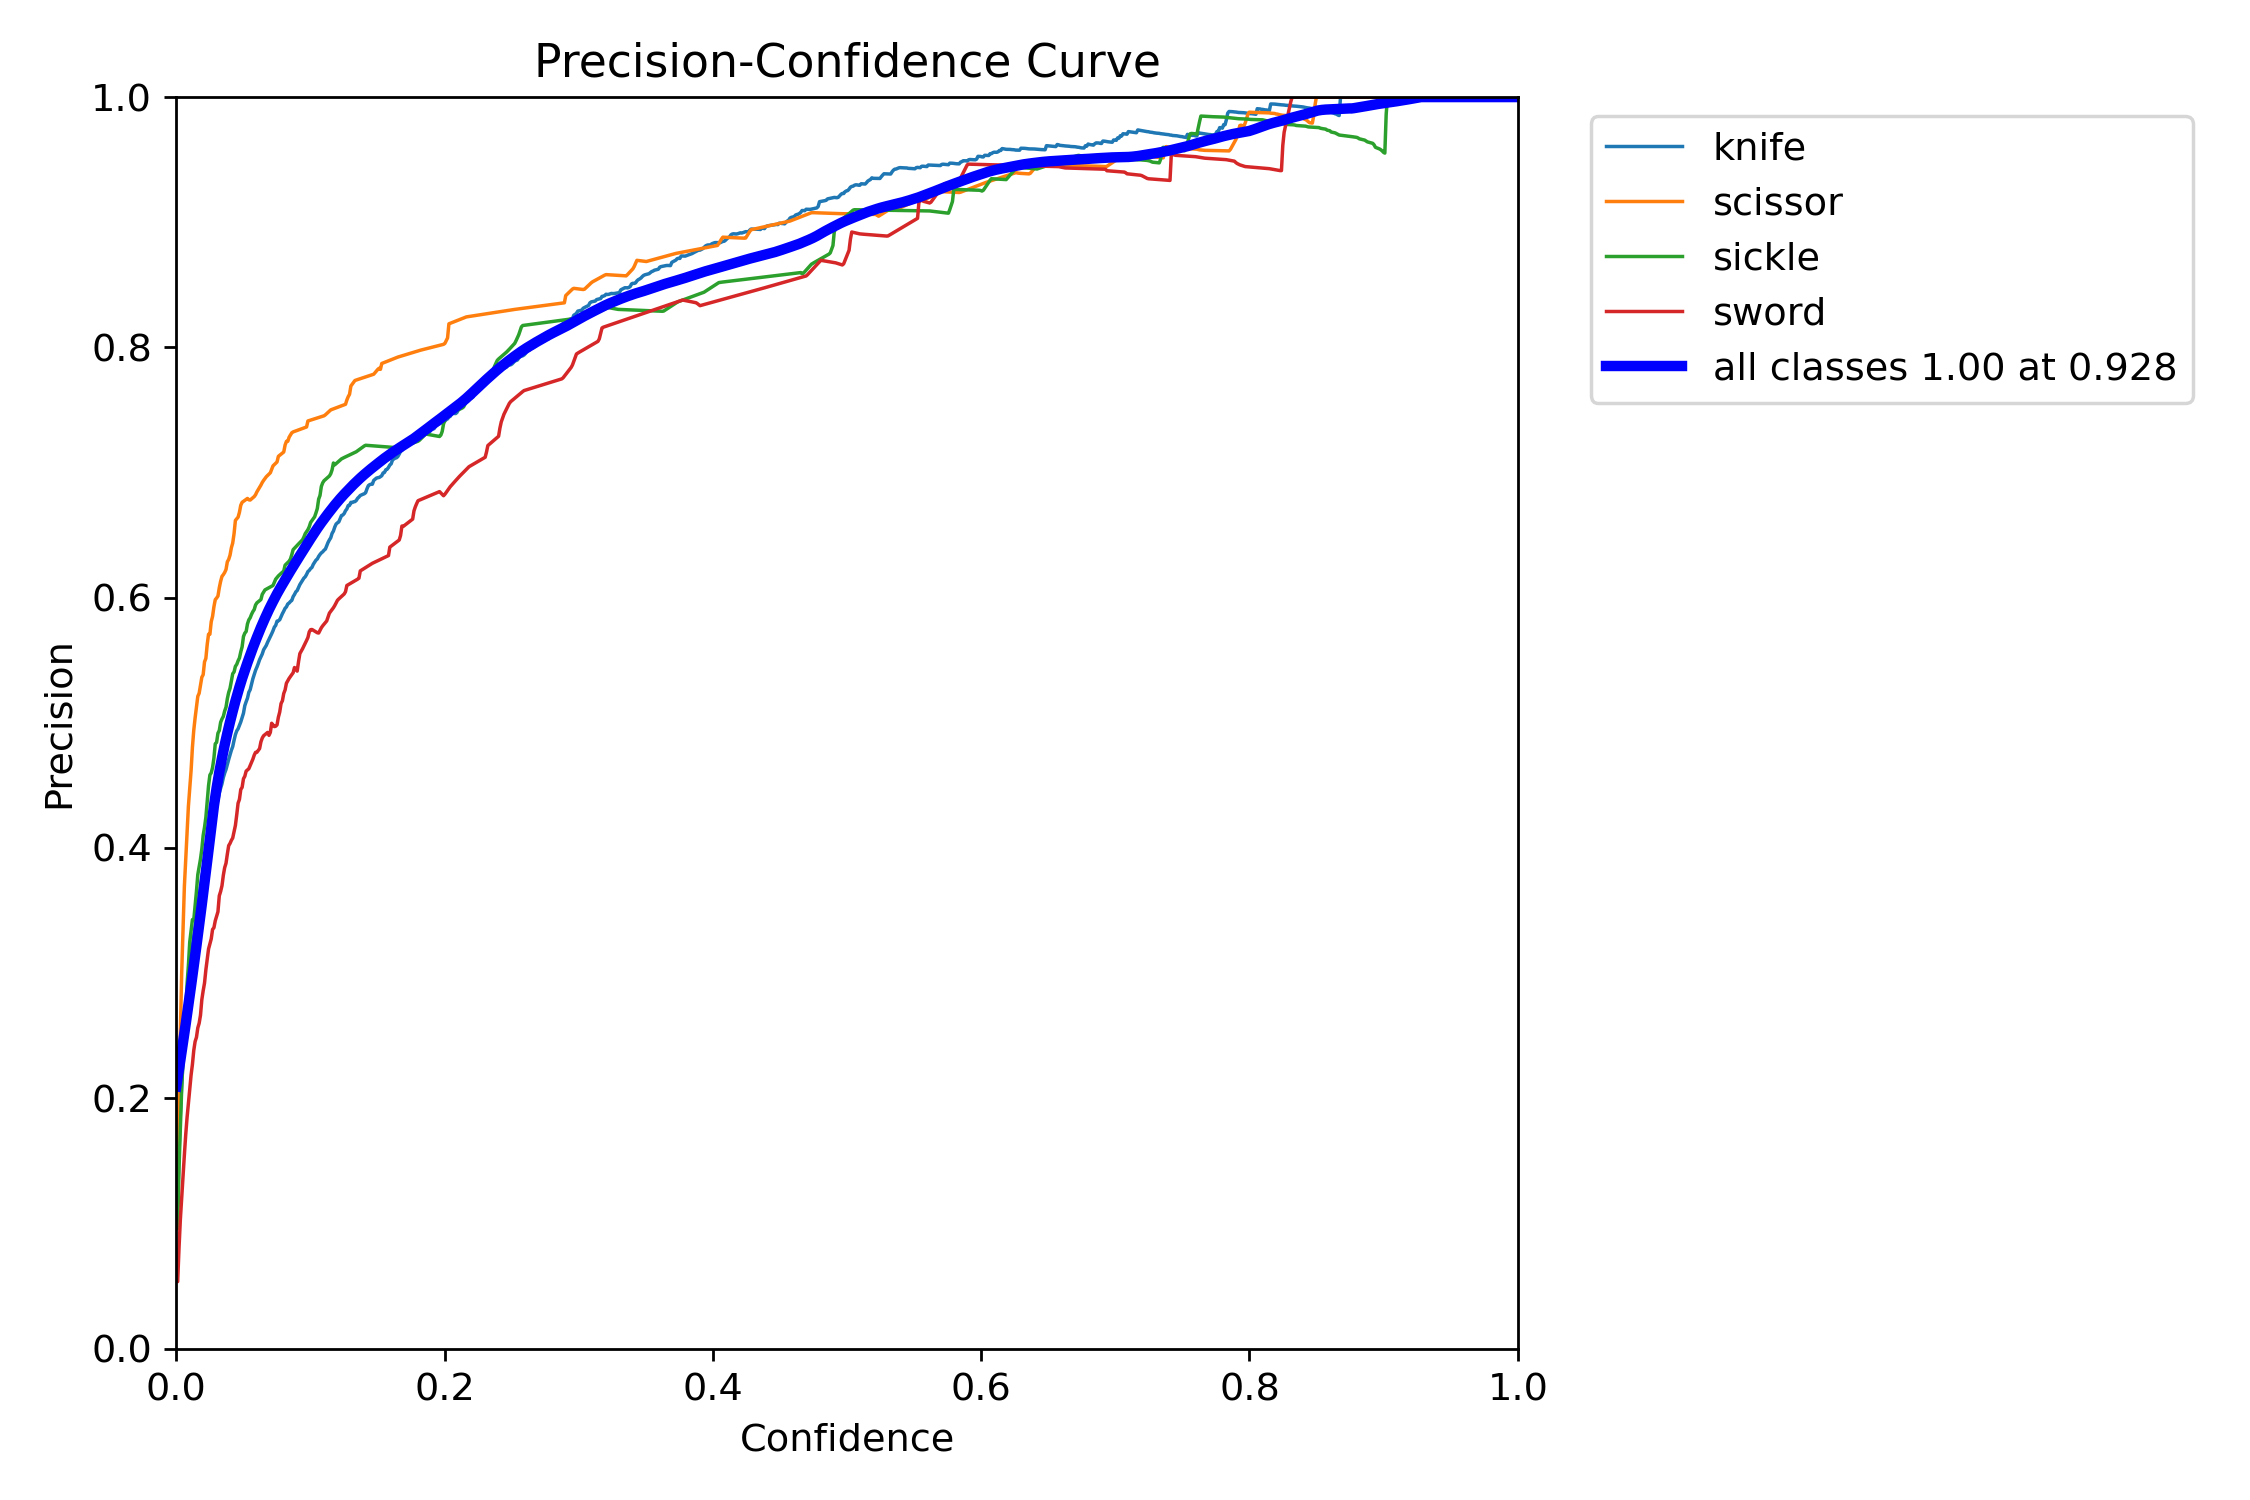

In [16]:
Image.open(f"runs/detect/train2/P_curve.png")

In [ ]:
Image.open(f"runs/detect/train/PR_curve.png")

In [ ]:
Image.open(f"runs/detect/train/val_batch0_pred.jpg")

<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>✅6. Inference with Train Dataset✅</b></font>
</div>

In [15]:
inference_results = model("datasets/test/images", device = 0, conf = 0.6)


image 1/568 /mnt/c/PESSOAL/FIAP/project005/datasets/test/images/00001.jpg: 640x640 1 knife, 140.5ms
image 2/568 /mnt/c/PESSOAL/FIAP/project005/datasets/test/images/00002.jpg: 640x640 1 knife, 45.4ms
image 3/568 /mnt/c/PESSOAL/FIAP/project005/datasets/test/images/00003.jpg: 640x640 (no detections), 11.2ms
image 4/568 /mnt/c/PESSOAL/FIAP/project005/datasets/test/images/00004.jpg: 640x640 1 knife, 9.8ms
image 5/568 /mnt/c/PESSOAL/FIAP/project005/datasets/test/images/00005.jpg: 640x640 1 knife, 10.1ms
image 6/568 /mnt/c/PESSOAL/FIAP/project005/datasets/test/images/00006.jpg: 640x640 (no detections), 9.8ms
image 7/568 /mnt/c/PESSOAL/FIAP/project005/datasets/test/images/00007.jpg: 640x640 1 knife, 10.8ms
image 8/568 /mnt/c/PESSOAL/FIAP/project005/datasets/test/images/00008.jpg: 640x640 1 knife, 9.8ms
image 9/568 /mnt/c/PESSOAL/FIAP/project005/datasets/test/images/00009.jpg: 640x640 1 knife, 9.9ms
image 10/568 /mnt/c/PESSOAL/FIAP/project005/datasets/test/images/00010.jpg: 640x640 1 knife, 10

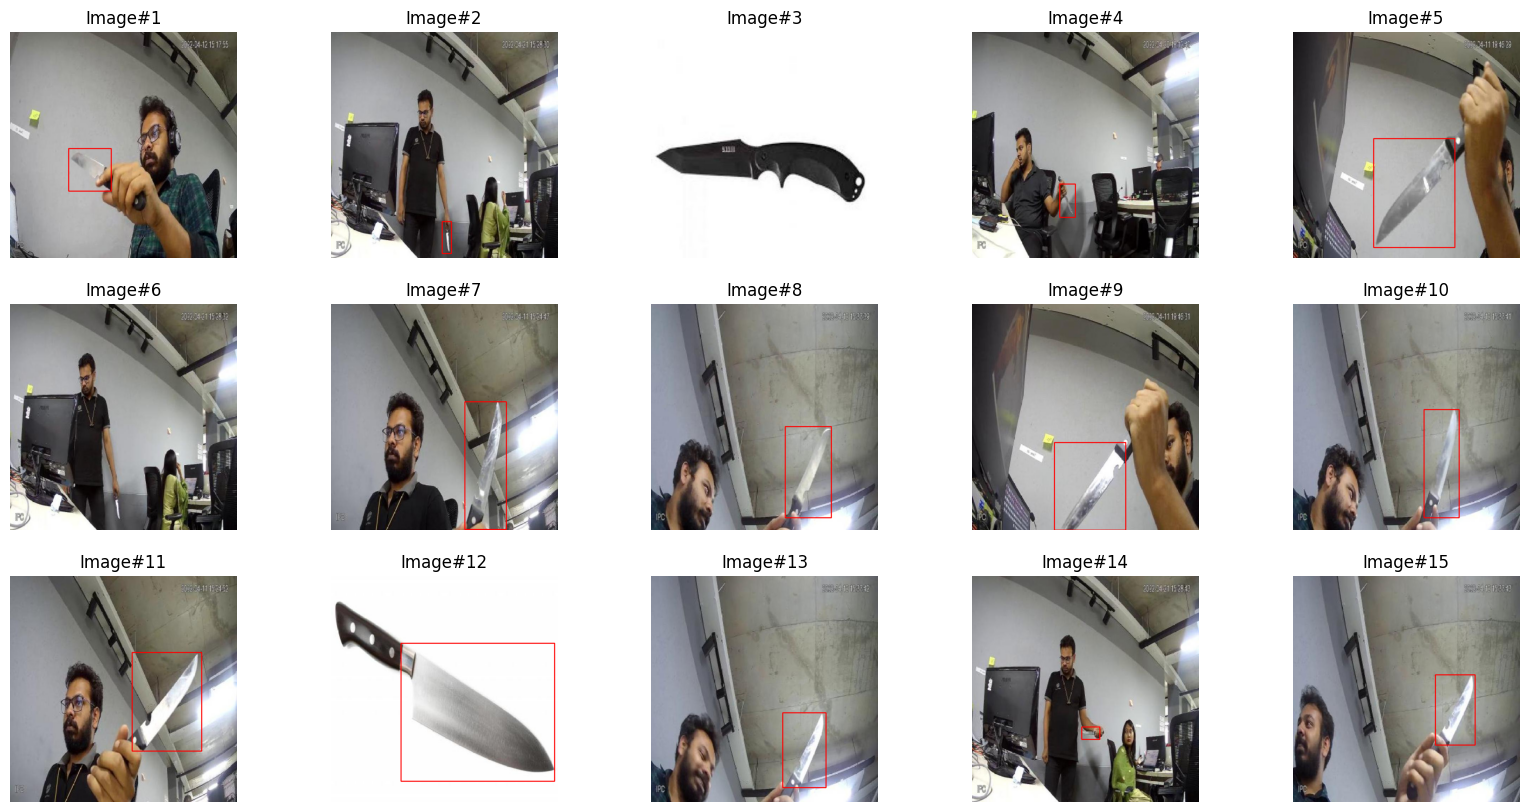

In [19]:
def inference_vis(res, n_ims, rows):
    import math
    
    # Close any existing figures
    plt.close('all')
    
    cols = math.ceil(n_ims / rows)
    plt.figure(figsize=(20, 10))
    
    for idx, r in enumerate(res):
        if idx == n_ims: break
        plt.subplot(rows, cols, idx + 1)
        or_im_rgb = np.array(Image.open(r.path).convert("RGB"))
        for i in r:
            for bbox in i.boxes:
                box = bbox.xyxy[0]
                x1, y1, x2, y2 = box
                coord1, coord2 = (int(x1), int(y1)), (int(x2), int(y2))
                cv2.rectangle(or_im_rgb, coord1, coord2, color=(255,0,0), thickness=2)
        plt.imshow(or_im_rgb)
        plt.title(f"Image#{idx + 1}")
        plt.axis("off")

inference_vis(res = inference_results, n_ims = 15, rows = 3)

In [17]:
def send_detection_email(sender_email, sender_password, receiver_email, inference_results):
    import smtplib
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    from email.mime.image import MIMEImage
    import io
    import math
    from datetime import datetime

    # Filter only results with detections
    detected_results = []
    for result in inference_results:
        if result and len(result) > 0 and result[0] and len(result[0].boxes) > 0:
            detected_results.append(result)
    
    if not detected_results:
        print("No weapons detected in any image. No email sent.")
        return

    # Calculate number of emails needed
    total_images = len(detected_results)
    images_per_email = 5
    num_emails = math.ceil(total_images / (images_per_email * 15))  # 15 images per attachment, 5 attachments per email

    for email_num in range(num_emails):
        # Create message container
        msg = MIMEMultipart()
        msg['From'] = sender_email
        msg['To'] = receiver_email
        msg['Subject'] = f'Weapon Detection Alert {email_num + 1}/{num_emails} - {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        # Create the body of the message
        start_idx = email_num * images_per_email * 15
        end_idx = min((email_num + 1) * images_per_email * 15, total_images)
        body = f'Alert: Weapons detected - Batch {email_num + 1} of {num_emails}\nShowing detections {start_idx + 1} to {end_idx} of {total_images} total detections.'
        msg.attach(MIMEText(body, 'plain'))

        # Process batches for this email
        current_results = detected_results[start_idx:end_idx]
        batch_size = 15
        num_batches = min(5, math.ceil(len(current_results) / batch_size))

        for batch in range(num_batches):
            batch_start = batch * batch_size
            batch_end = min((batch + 1) * batch_size, len(current_results))
            current_batch = current_results[batch_start:batch_end]
            
            plt.close('all')
            plt.figure(figsize=(20, 10))
            inference_vis(current_batch, n_ims=len(current_batch), rows=3)
            
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            
            image = MIMEImage(buf.read())
            image.add_header('Content-ID', f'<detection_results_batch_{batch+1}>')
            image.add_header('Content-Disposition', f'attachment; filename="weapon_detection_email{email_num+1}_batch_{batch+1}.png"')
            msg.attach(image)
            plt.close()

        # Setup Microsoft 365 server
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        
        try:
            # Login and send email
            server.login(sender_email, sender_password)
            server.send_message(msg)
            print(f"Alert email sent successfully with {num_batches} attachments containing {total_images} detected weapons!")
        except Exception as e:
            print(f"Error sending email: {str(e)}")
        finally:
            server.quit()

In [20]:

# Example usage
sender_email = "razielxblade@gmail.com"
sender_password = "lwqv ycak ojgo ploe"  # Use App Password from Google Account
receiver_email = "rm355886@fiap.com.br"

send_detection_email(
    sender_email,
    sender_password,
    receiver_email,
    inference_results
)


Alert email sent successfully with 5 attachments containing 447 detected weapons!
Alert email sent successfully with 5 attachments containing 447 detected weapons!
Alert email sent successfully with 5 attachments containing 447 detected weapons!
Alert email sent successfully with 5 attachments containing 447 detected weapons!
Alert email sent successfully with 5 attachments containing 447 detected weapons!
Alert email sent successfully with 5 attachments containing 447 detected weapons!
